## Week 7 - Project 2

### Josh Iden 

### 3/12/23

## Assignment

Watch: [presentation](https://youtu.be/Vf9AXL4gm8E)

![](PJ2.png)

This report looks at the [Facebook-like Forum Network](https://networkrepository.com/fb-forum.php) data from Network Repository. 

**Description:**	The Facebook-like Forum Network was attained from the same online community as the online social network; however, the focus in this network is not on the private messages exchanged among users, but on users’ activity in the forum.

The dataset contains two different types of nodes: `users`, and `topics`, with a weight assigned in a message column to represent the length of the message in characters, although I was unable to find how the calculation of this figure was determined.

## Approach  

The main challenge of this project was securing appropriate bipartite data to perform analysis. I worked with several datasets until landing on the facebook data. The data required some transformation in order to create a working bipartite graph. 

In [1]:
import networkx as nx
from networkx.algorithms import bipartite as bi
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
file = 'fb-forum.edges'

In [3]:
df = pd.read_csv(file, header=None, names=['users','topics','messages'])

In [4]:
df.head()

,users,topics,messages
0,428,538,1084585996
1,374,538,1084586048
2,231,452,1084586140
3,2,538,1084586404
4,187,538,1084586537


The users and topics use the same integer naming convention, so to distinguish them I'll add a T to each topic integer.

In [5]:
df['topics'] = df['topics'].astype(str) +'T'
df.head()

,users,topics,messages
0,428,538T,1084585996
1,374,538T,1084586048
2,231,452T,1084586140
3,2,538T,1084586404
4,187,538T,1084586537


In [6]:
df.messages.describe()

count    3.372000e+04
mean     1.087883e+09
std      3.379303e+06
min      1.084586e+09
25%      1.085607e+09
50%      1.086305e+09
75%      1.089226e+09
max      1.098798e+09
Name: messages, dtype: float64

The `messages` values are all in a similar, so I'll perform some transformations to try to make them more easily distinguishable.

In [7]:
df['messages'] = (df['messages']/df['messages'].abs().max() * 1000).astype(int)
df.describe()

,users,messages
count,33720.000000,33720.000000
mean,383.532384,989.583215
std,265.160146,3.079820
min,1.000000,987.000000
25%,120.000000,987.000000
50%,369.500000,988.000000
75%,592.000000,991.000000
max,899.000000,1000.000000


In [8]:
users = list(df['users'].unique())
topics = list(df['topics'].unique())
# scale the messages column

G = nx.Graph()

G.add_nodes_from(users, bipartite=0)
G.add_nodes_from(topics, bipartite=1)

In [9]:
%%time 

for index, row in df.iterrows():
    G.add_edge(row[0], row[1], weight=row[2])

CPU times: user 2.96 s, sys: 42.7 ms, total: 3 s
Wall time: 3.87 s


In [10]:
nx.is_connected(G)

False

In [11]:
nx.is_bipartite(G)

True

The graph is not connected, but it is bipartite. Let's grab the largest connected component.

In [12]:
g = max(nx.connected_component_subgraphs(G),key=len)

In [13]:
nx.is_connected(g)

True

In [14]:
nx.is_bipartite(g)

True

In [15]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 1417
Number of edges: 7087
Average degree:  10.0028


In [16]:
def graph_summary(graph):
    degree = pd.Series(dict(nx.degree(graph)),name='degree')
    weight = pd.Series(dict(nx.degree(graph, weighted=True)),name='weight')
    closeness = pd.Series(dict(nx.closeness_centrality(graph)),name='closeness_centrality')
    degree_centrality = pd.Series(dict(nx.degree_centrality(graph)),name='degree_centrality')
    betweenness = pd.Series(dict(nx.betweenness_centrality(graph)),name='betweenness_centrality')
    eigen_centrality = pd.Series(dict(nx.eigenvector_centrality(graph)),name='eigenvector_centrality')
    
    return pd.concat([degree, weight, closeness, degree_centrality, betweenness, eigen_centrality], axis=1).sort_values(by='degree', ascending=False).reset_index().rename(columns={"index":"node"})


/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:133: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = pylab.ishold()
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:502: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:523: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color)==1:
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:718: MatplotlibDeprecationWarning: The is_string_like function was deprec

CPU times: user 905 ms, sys: 44.2 ms, total: 950 ms
Wall time: 1.36 s


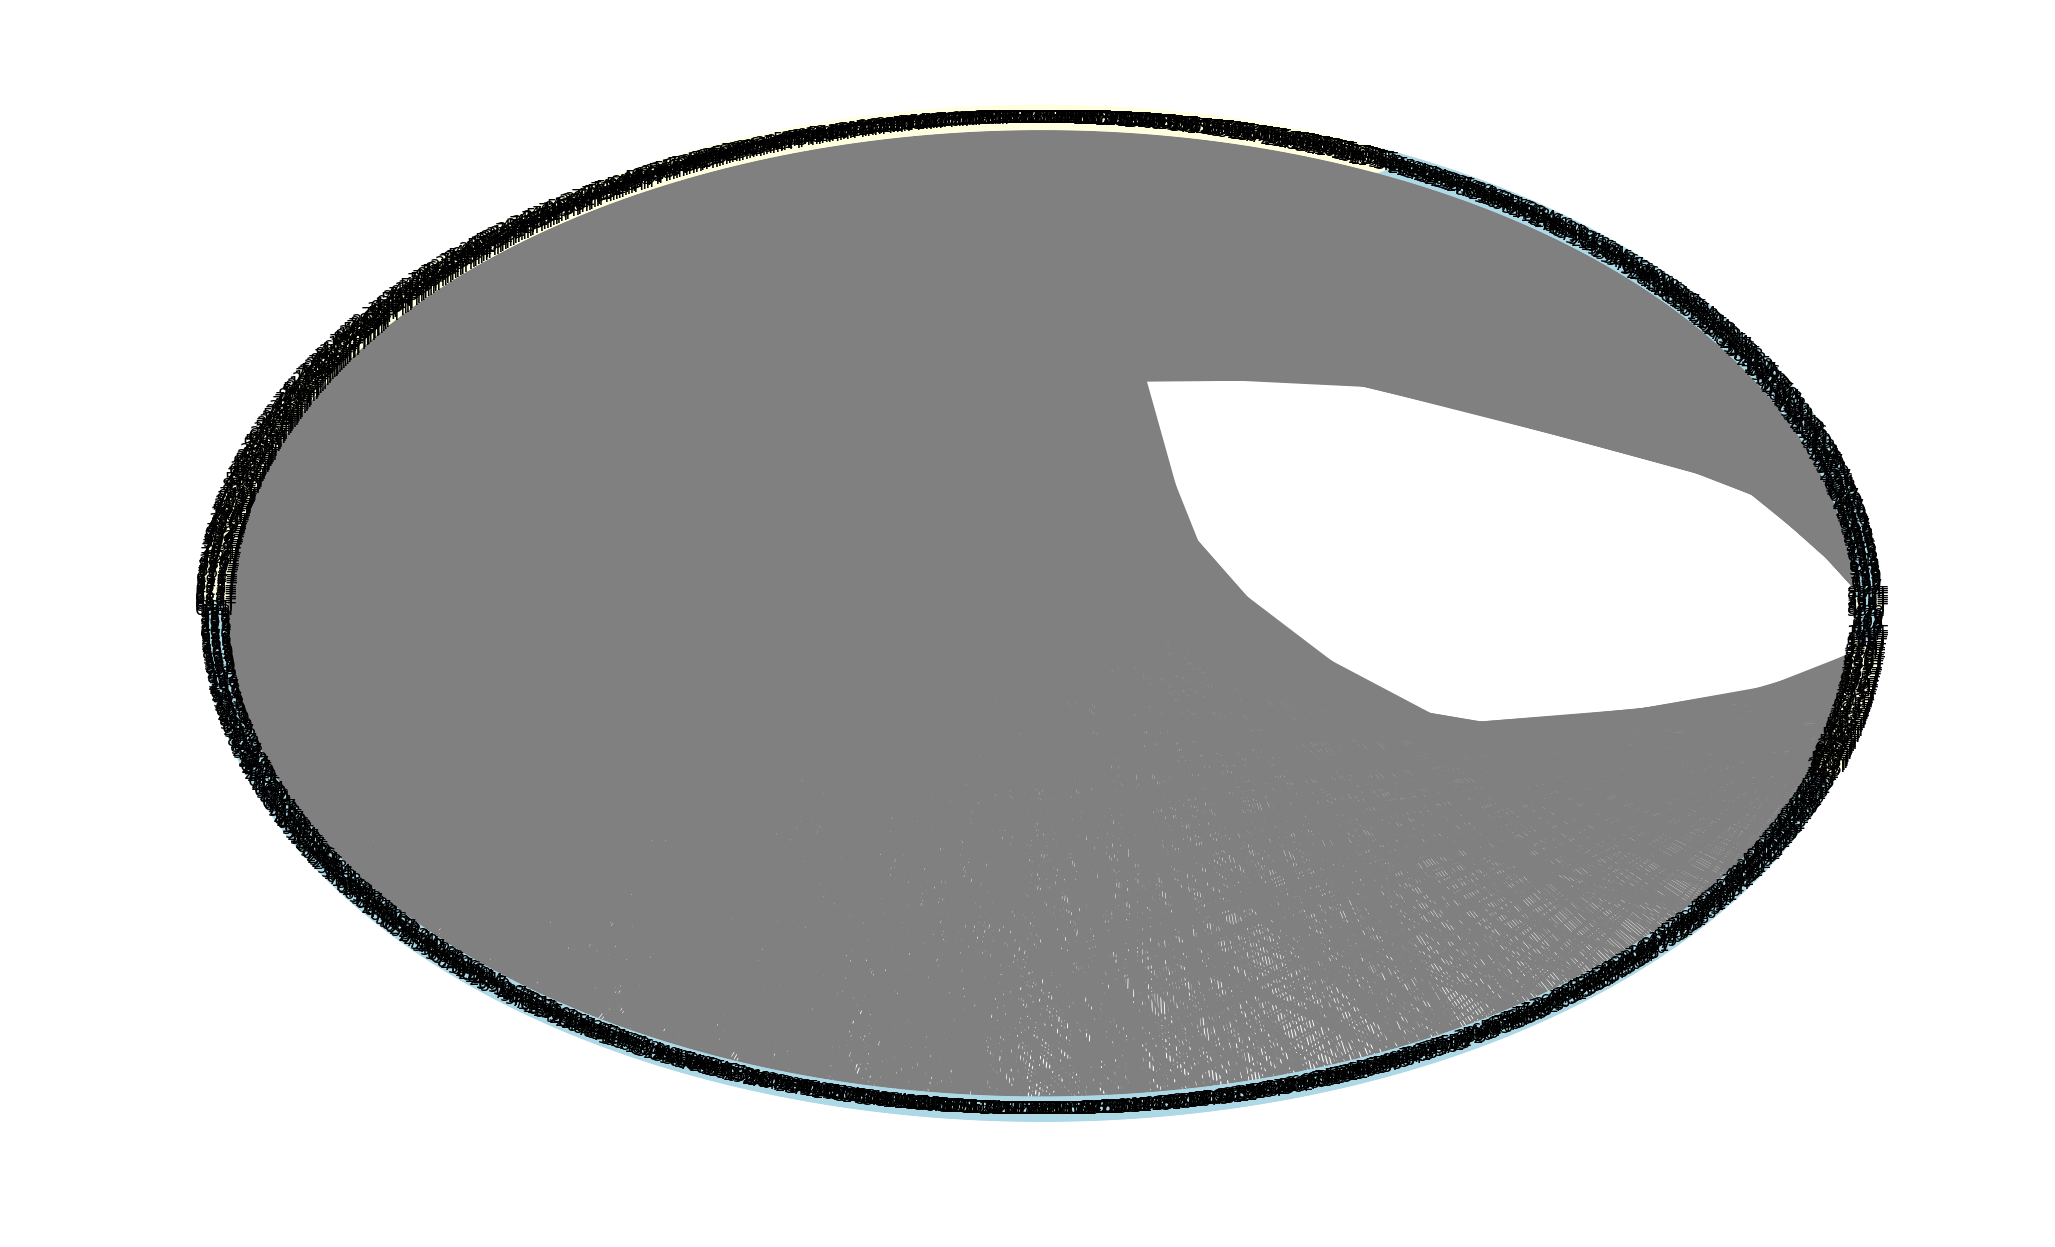

In [17]:
%%time
colors = ['lightyellow' if d['bipartite']==1 else 'lightblue' for n, d in g.nodes(data=True)]
weights = np.log([edata['weight'] for n,e,edata in g.edges(data=True)])/4
degs = dict(g.degree()).values()
seed=456
plt.figure(figsize=[20,12])
nx.draw_circular(g, width=weights, node_color=colors, edge_color='grey');

It is clear the network is far too large to make visual sense of at this stage. Let's reduce the network using the island method. 

### Island Method

In [18]:
def trim_edges(g, weight=1):
    """
    Takes a graph, and applies a threshold (“water level”), 
    letting all edges above a certain value through, and removing all others. 
    
    It returns a copy of the original graph, so it’s non-destructive
    """
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f, to, **edata)
    
    return g2

def island_method(g, iterations=5):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    mn = int(min(weights))
    mx = int(max(weights))
    # compute the size of the step, so we get a reasonable step in iterations
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [19]:
%%time

islands = island_method(g)
print('threshold','\t\t','size','\t\t','conn. components')
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print (i[0],'\t\t\t', len(i[1]), '\t\t\t',len(list(nx.connected_components(i[1]))))

threshold 		 size 		 conn. components
987 			 1278 			 2
989 			 816 			 3
991 			 705 			 5
993 			 625 			 7
995 			 559 			 13
997 			 392 			 20
999 			 2 			 1
CPU times: user 287 ms, sys: 19.4 ms, total: 307 ms
Wall time: 535 ms


In [20]:
g_trim = trim_edges(g, 997)

CPU times: user 912 ms, sys: 13.6 ms, total: 925 ms
Wall time: 1.15 s


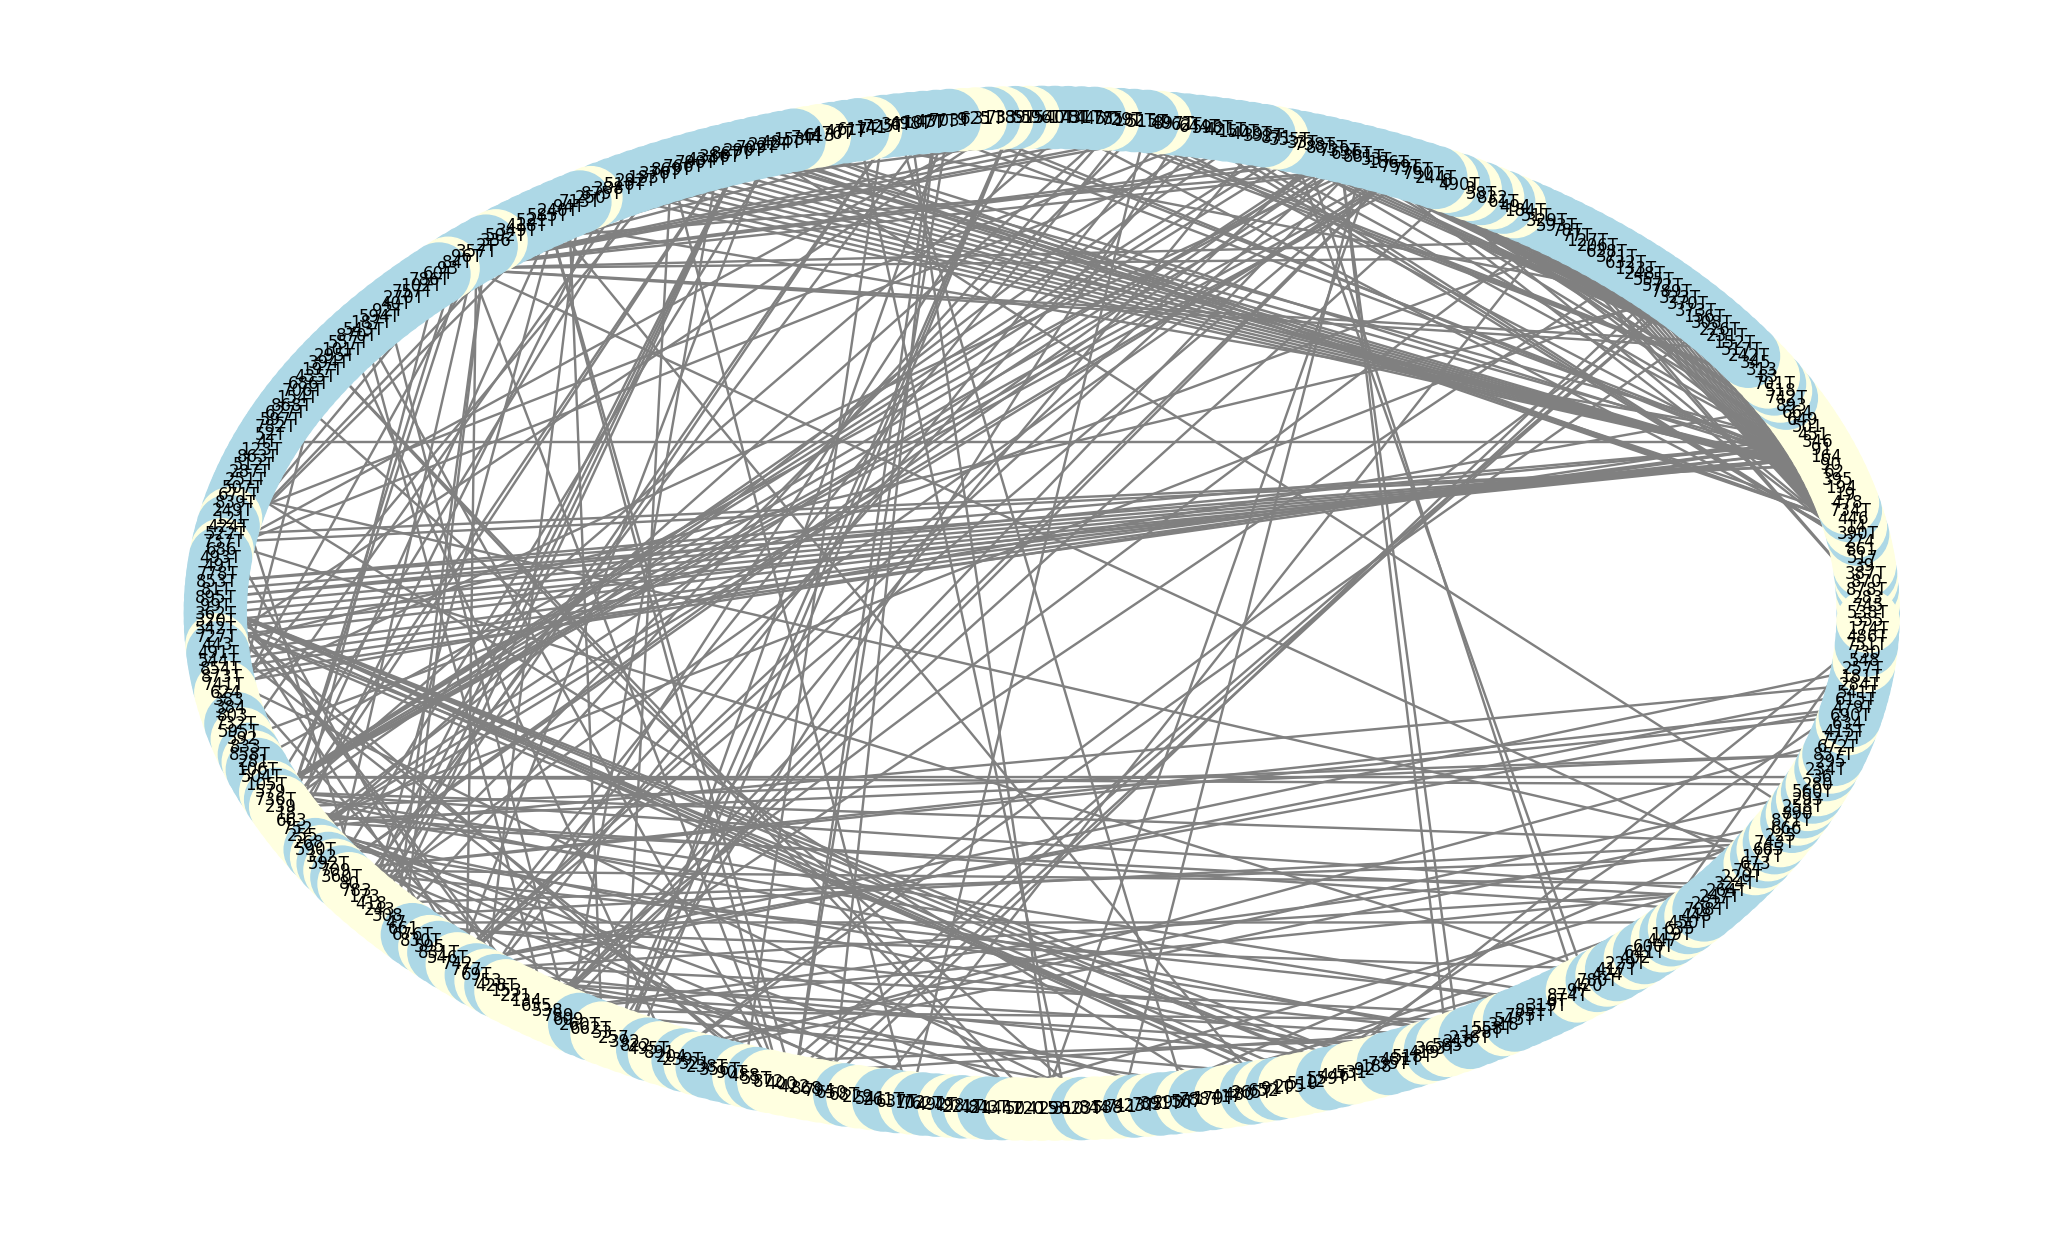

In [21]:
%%time
colors = ['lightyellow' if n in users else 'lightblue' for n in g_trim.nodes()]
weights = np.log([edata['weight'] for n,e,edata in g_trim.edges(data=True)])/4
degs = dict(g_trim.degree()).values()
seed=456
plt.figure(figsize=[20,12])
nx.draw_circular(g_trim, width=weights, node_color=colors, node_size=2000, edge_color='grey');

We can get a sense of a few different clusters, but there are still far too many nodes in the network to be able identify which users or topics are the most influential. Let's project the bipartite nodes onto their own graphs and see if we can identify any characteristics of each. 

### Looking at Users

/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:133: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = pylab.ishold()
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:502: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:523: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color)==1:
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:718: MatplotlibDeprecationWarning: The is_string_like function was deprec

CPU times: user 15.8 s, sys: 246 ms, total: 16.1 s
Wall time: 17.1 s


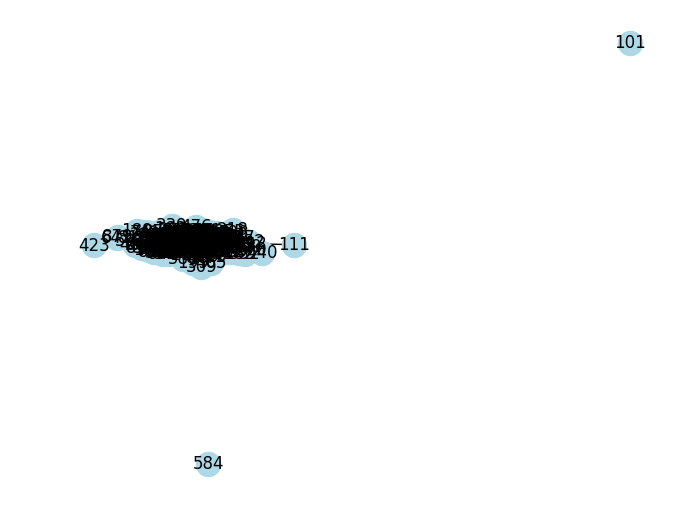

In [22]:
%%time

u = bi.weighted_projected_graph(G, users)
weights = [np.log(edata['weight'])**0.1 for n,e,edata in u.edges(data=True)]
nx.draw_spring(u, node_color='lightblue', with_labels=True, node_size =300);

#### Island Method - Users

In [23]:
%%time

islands = island_method(u)
print('threshold','\t\t','size','\t\t','conn. components')
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print (i[0],'\t\t\t', len(i[1]), '\t\t\t',len(list(nx.connected_components(i[1]))))

threshold 		 size 		 conn. components
1 			 659 			 1
7 			 112 			 1
13 			 33 			 3
19 			 9 			 1
25 			 4 			 1
CPU times: user 769 ms, sys: 28.6 ms, total: 797 ms
Wall time: 818 ms


In [24]:
%%time
weights = np.log([edata['weight'] for n,e,edata in u_trim.edges(data=True)])/2
seed=456
plt.figure(figsize=[20,12])
nx.draw_circular(u_trim, width=weights, node_color='lightblue', node_size=4000, edge_color='grey');

NameError: name 'u_trim' is not defined

Now it's obvious that user number 93 is highly influential and that there are a number of users who only connect with one another. 

In [25]:
%%time
u_trim = trim_edges(u, 13)
ut_df = graph_summary(u_trim)
ut_df = ut_df.rename({'node':'user'}, axis=1)
ut_df.head()

CPU times: user 66.4 ms, sys: 4.26 ms, total: 70.7 ms
Wall time: 71.8 ms


,user,degree,weight,closeness_centrality,degree_centrality,betweenness_centrality,eigenvector_centrality
0,93,22,397,0.704167,0.68750,0.542910,0.556646
1,637,9,167,0.469444,0.28125,0.026008,0.396683
2,9,7,123,0.440104,0.21875,0.010753,0.323715
3,592,7,138,0.449468,0.21875,0.057090,0.342806
4,39,5,100,0.431122,0.15625,0.025269,0.251208


#### Users: Closeness Centrality

In [26]:
ut_df[['user','closeness_centrality']].sort_values(by='closeness_centrality', ascending=False).head()

,user,closeness_centrality
0,93,0.704167
1,637,0.469444
3,592,0.449468
2,9,0.440104
4,39,0.431122


#### Users: Degree Centrality

In [27]:
ut_df[['user','degree_centrality']].sort_values(by='degree_centrality', ascending=False).head()

,user,degree_centrality
0,93,0.68750
1,637,0.28125
2,9,0.21875
3,592,0.21875
4,39,0.15625


#### Users: Betweenness Centrality

In [28]:
ut_df[['user','betweenness_centrality']].sort_values(by='betweenness_centrality', ascending=False).head()

,user,betweenness_centrality
0,93,0.542910
3,592,0.057090
14,8,0.050403
16,395,0.050403
1,637,0.026008


#### Users: Eigenvector Centrality

In [29]:
ut_df[['user','eigenvector_centrality']].sort_values(by='eigenvector_centrality', ascending=False).head()

,user,eigenvector_centrality
0,93,0.556646
1,637,0.396683
3,592,0.342806
2,9,0.323715
4,39,0.251208


#### Inferences

We can see that user 93 is the most connected user across every metric. It has *by far* the highest **degree centrality**, or proportion of number of edges to total edges, of any node, as well as, again, by far, the largest **betweenness centrality**, lying on the most paths between other nodes. 

The centrality measures amongs all nodes tend to be similarly distributed, as the top 5 highest measurements are consistent between nodes, with the exception of node 8, which appears in the betweenness centrality category -- although it's score is so low the only inference it has many weak connections with other nodes. 

### Looking at Topics  

/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:133: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = pylab.ishold()
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:502: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:523: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color)==1:
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:718: MatplotlibDeprecationWarning: The is_string_like function was deprec

CPU times: user 9.02 s, sys: 167 ms, total: 9.19 s
Wall time: 9.81 s


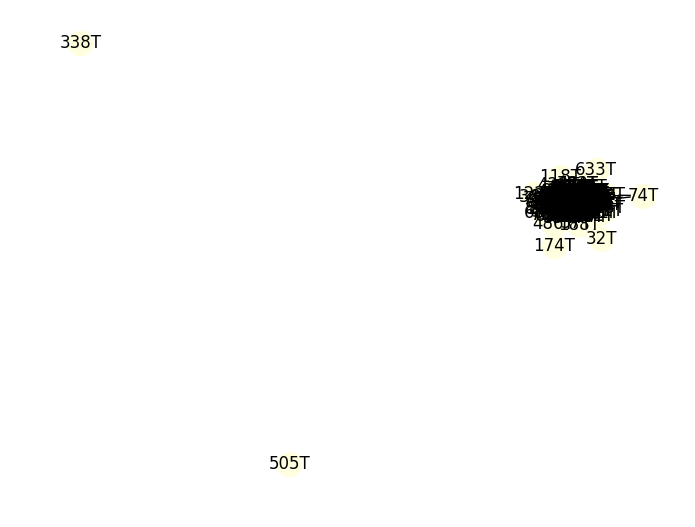

In [30]:
%%time

t = bi.weighted_projected_graph(G, topics)
weights = [np.log(edata['weight'])**0.1 for n,e,edata in t.edges(data=True)]
nx.draw_spring(t, node_color='lightyellow', with_labels=True, node_size=300);

#### Island Method - Topics

In [31]:
%%time

islands = island_method(t)
print('threshold','\t\t','size','\t\t','conn. components')
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print (i[0],'\t\t\t', len(i[1]), '\t\t\t',len(list(nx.connected_components(i[1]))))

threshold 		 size 		 conn. components
1 			 462 			 1
8 			 101 			 2
15 			 32 			 2
22 			 13 			 1
29 			 6 			 3
36 			 2 			 1
CPU times: user 438 ms, sys: 14.3 ms, total: 453 ms
Wall time: 465 ms


CPU times: user 135 ms, sys: 7.53 ms, total: 143 ms
Wall time: 140 ms


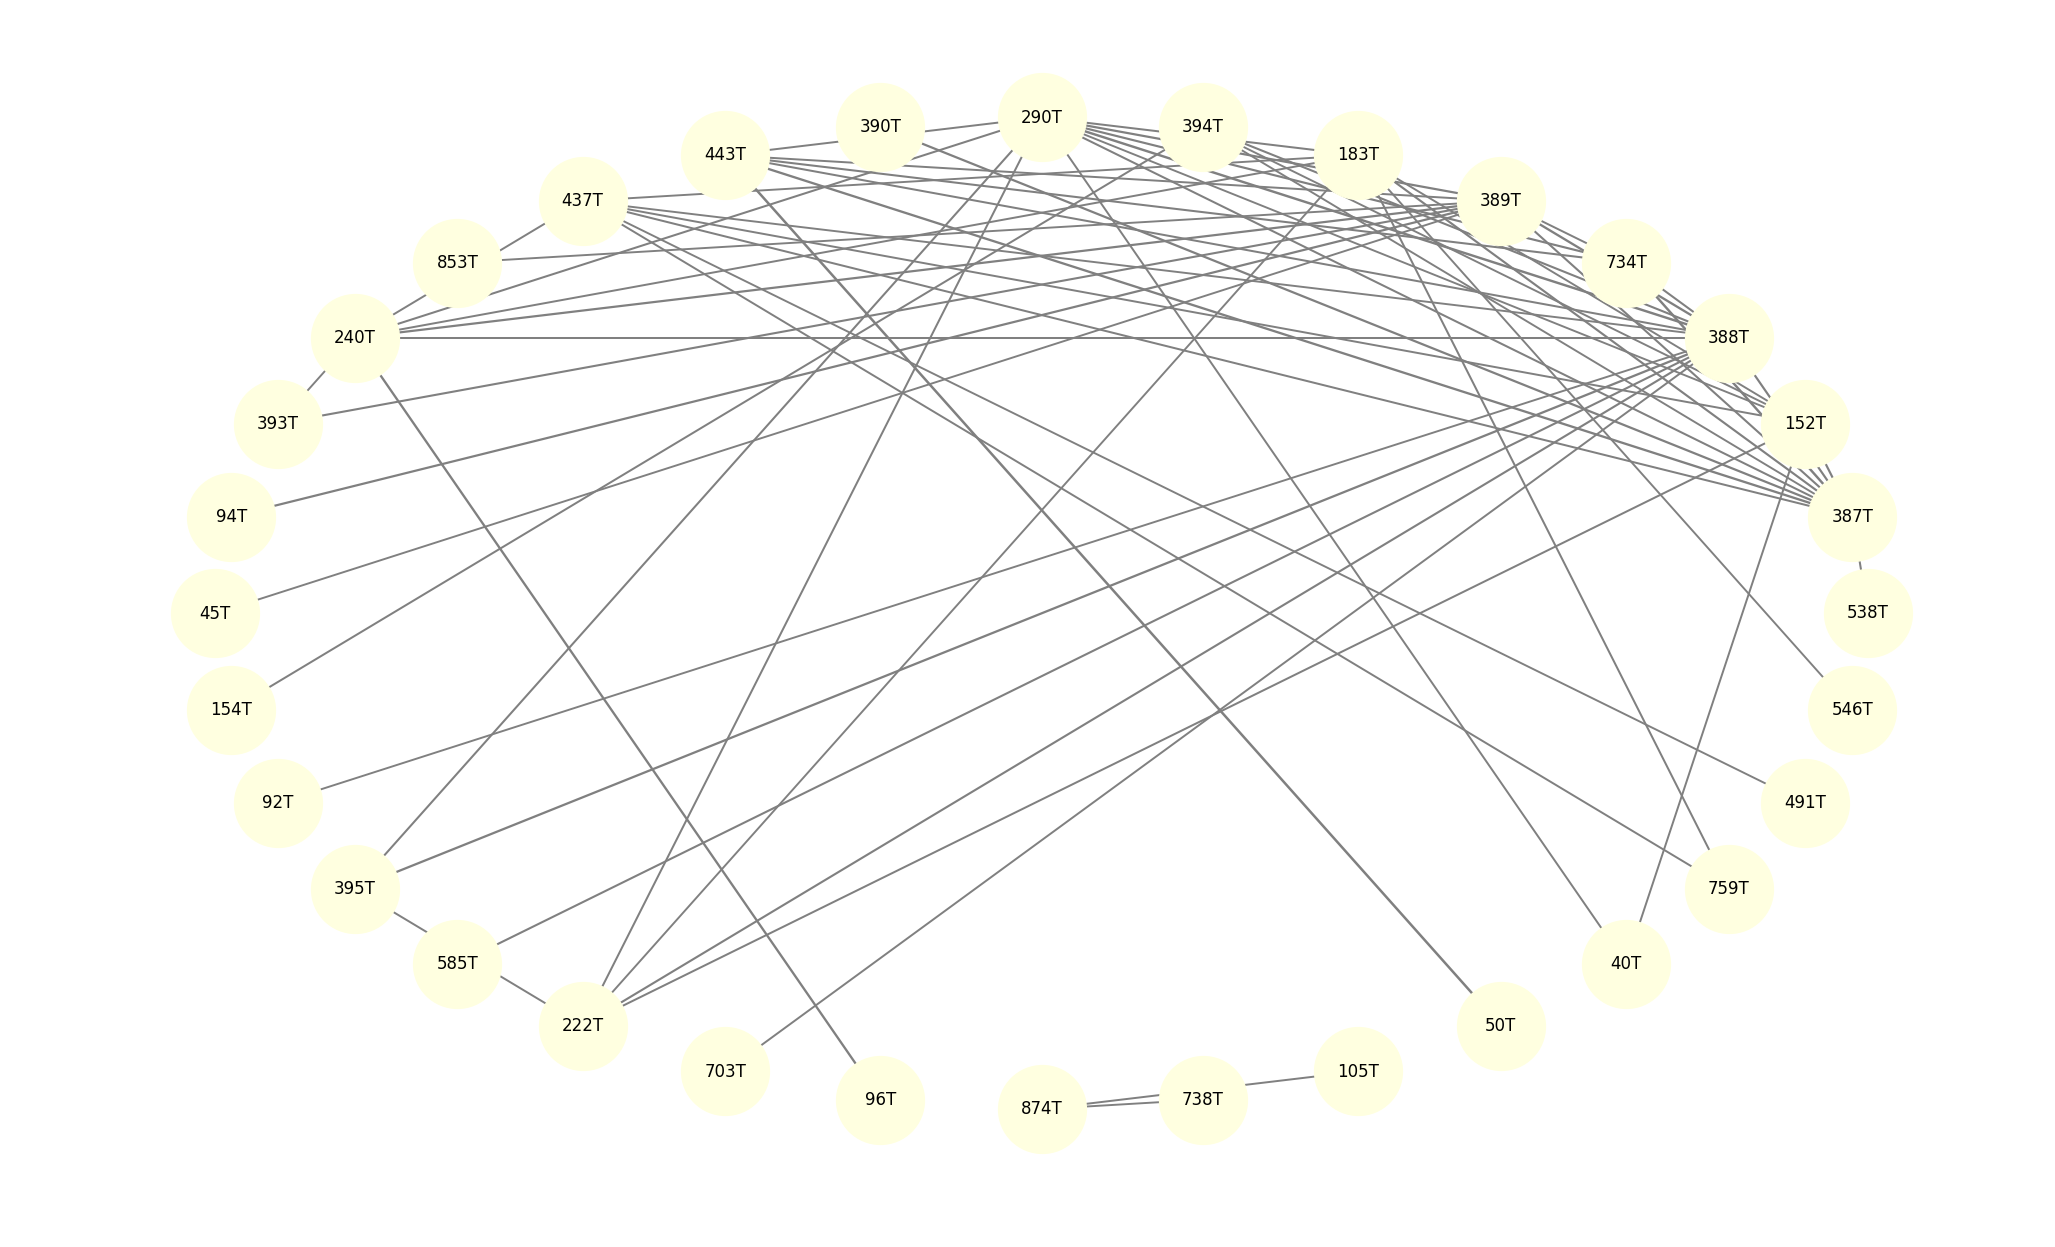

In [32]:
%%time
t_trim = trim_edges(t, 15)
weights = np.log([edata['weight'] for n,e,edata in t_trim.edges(data=True)])/2
seed=456
plt.figure(figsize=[20,12])
nx.draw_circular(t_trim, width=weights, node_color='lightyellow', node_size=4000, edge_color='grey');

We can observe that topics 240T, 387T, and 389T are the most influential topics, and there are some open triangles between all three of those topics, suggesting there may be some predictive capacity for users responding strongly to simliar topics. 

In [33]:
t_df = graph_summary(t_trim)
t_df = t_df.rename({'node':'topic'}, axis=1)
t_df.head()

,topic,degree,weight,closeness_centrality,degree_centrality,betweenness_centrality,eigenvector_centrality
0,388T,13,275,0.574780,0.419355,0.260717,0.417839
1,290T,11,222,0.538092,0.354839,0.105878,0.396883
2,387T,11,246,0.549790,0.354839,0.185233,0.391820
3,389T,10,206,0.505806,0.322581,0.199642,0.326264
4,183T,8,139,0.451613,0.258065,0.092222,0.201366


#### Topics: Closeness Centrality

In [34]:
t_df[['topic','closeness_centrality']].sort_values(by='closeness_centrality', ascending=False).head()

,topic,closeness_centrality
0,388T,0.574780
2,387T,0.549790
1,290T,0.538092
3,389T,0.505806
7,240T,0.477176


#### Topics: Degree Centrality

In [35]:
t_df[['topic','degree_centrality']].sort_values(by='degree_centrality', ascending=False).head()

,topic,degree_centrality
0,388T,0.419355
2,387T,0.354839
1,290T,0.354839
3,389T,0.322581
4,183T,0.258065


#### Topics: Betweenness Centrality

In [36]:
t_df[['topic','betweenness_centrality']].sort_values(by='betweenness_centrality', ascending=False).head()

,topic,betweenness_centrality
0,388T,0.260717
3,389T,0.199642
2,387T,0.185233
1,290T,0.105878
7,240T,0.098996


#### Topics: Eigenvector Centrality

In [37]:
t_df[['topic','eigenvector_centrality']].sort_values(by='eigenvector_centrality', ascending=False).head()

,topic,eigenvector_centrality
0,388T,0.417839
1,290T,0.396883
2,387T,0.391820
3,389T,0.326264
9,734T,0.277090


#### Inferences  

Topics are much more evenly distributed than users in terms of there is not one topic that is siginficantly more "important" than another. We observe that topics 290T, 387T, 388T, and 389T are comparable in terms of all centrality measurements, which makes sense from the graph. In the graph, however, we can see that 437T and 443T seem to have a high number of edges, and these could represent open triad relationships that could indicate which topics are likely to relate to one another. 

### Conclusion

The small variation in the weight of the edges (message size) made this network challenging in terms of implementing the island method to identify smaller connected subgraphs of higher import. Because the smallest identifiable subgroup was too large to visualize the full graph, we were unable to establish a visual relationship between the users and topics. We were, however, able to identify within each bipartite graph, the influential and important members. In `users`, users 93, 637, 592, and 9 are the most influential users amongst the strongest messages in terms of weight. In `topics`, topics 290T, 387T, 388T, and 389T are the most influential and important amongst messages generating the strongest response in terms of message weight. 